# Muruki Analytics P1

## Imports

In [1]:
#misc
from __future__ import division
import os 
import time
import random
import dill as pkl
#ds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#torch
import torch 
import torch.nn as nn
from torch.autograd import Variable
#model
from darknet import Darknet
from bbox import bbox_iou
import cv2
CUDA = torch.cuda.is_available()

#path
VIDEO_PATH = 'video/'
STREAM_PATH = 'stream/'

#util functions


## Model Setup

In [3]:
#parameters
scales = [1,2,3]
scales_indices = []
reso = 320
num_boxes = [reso//8, reso//16, reso//32]
num_boxes = sum([3*(x**2) for x in num_boxes])

for scale in scales:
    li = list(range((scale - 1)* num_boxes // 3, scale * num_boxes // 3))
    scales_indices.extend(li)

confidence = 0.5
nms_thesh = 0.4

def load_classes(namesfile):
    fp = open(namesfile, "r")
    names = fp.read().split("\n")[:-1]
    return names
classes = load_classes('data/coco.names') 
num_classes = len(classes)

#load weights
model = Darknet('cfg/yolov3.cfg')
model.load_weights('weights/yolov3.weights')
model.eval()

#set size
model.net_info["height"] = reso
inp_dim = int(model.net_info["height"])

if CUDA: model.cuda()

## Read Video

In [4]:
def read_video(fname):
    cap = cv2.VideoCapture(fname)
    flag = True
    frames = []
    while flag:
        flag,frame = cap.read()
        if frame is not None:
            frames.append(frame)
    return(frames)

video_list = read_video(VIDEO_PATH+'sample_video.avi')

## Create Frame Batches

In [5]:
def prep_image(img, inp_dim):
    orig_im = img
    dim = orig_im.shape[1], orig_im.shape[0]
    img = cv2.resize(orig_im, (inp_dim, inp_dim))
    img_ = img[:,:,::-1].transpose((2,0,1)).copy()
    img_ = torch.from_numpy(img_).float().div(255.0).unsqueeze(0)
    return img_, orig_im, dim

def get_frame_batches(video_list):
    frame_batches = list(map(prep_image, video_list, [inp_dim for x in range(len(video_list))]))
    im_batches = [x[0] for x in frame_batches]
    orig_ims = [x[1] for x in frame_batches]
    im_dim_list = [x[2] for x in frame_batches]
    im_dim_list = torch.FloatTensor(im_dim_list).repeat(1,2)
    if CUDA: im_dim_list = im_dim_list.cuda()
    for i in range(len(im_batches)): 
        if CUDA:
            im_batches[i] = im_batches[i].cuda()
    return(frame_batches,im_batches,orig_ims,im_dim_list)

one_frame = get_frame_batches(video_list)[1][900]

## Get Predictions

In [6]:
def get_prediction(one_frame):
    prediction = model(Variable(one_frame, volatile = True), CUDA)
    prediction = prediction[:,scales_indices]

    #schema for predictions
    #0-3: position related
    #4: objectness score
    #5-84: sigmoid class scores
    conf_mask = (prediction[:,:,4] > confidence).float().unsqueeze(2)
    prediction = prediction*conf_mask

    #torch.nonzero will get you the (dimension,position) of non-zero values
    #contiguous means not stored in memory
    #if don't find anything return 
    try:
        ind_nz = torch.nonzero(prediction[:,:,4]).transpose(0,1).contiguous()
    except:
        return(torch.zeros(1,7) + 999)
    #transform the output to box coordinates
    #from
    #0 - center x from top left of pic
    #1 - center y from top left of pic
    #2 - width
    #3 - height
    box_a = prediction.new(prediction.shape)
    box_a[:,:,0] = (prediction[:,:,0] - prediction[:,:,2]/2)
    box_a[:,:,1] = (prediction[:,:,1] - prediction[:,:,3]/2)
    box_a[:,:,2] = (prediction[:,:,0] + prediction[:,:,2]/2) 
    box_a[:,:,3] = (prediction[:,:,1] + prediction[:,:,3]/2)
    prediction[:,:,:4] = box_a[:,:,:4].squeeze(0)
    
    
    #Get the class having maximum score, and the index of that class
    #Get rid of num_classes softmax scores 
    #Add the class index and the class score of class having maximum score
    image_pred = prediction[0]
    max_conf_score, max_conf = torch.max(image_pred[:,5:5+ num_classes], 1)
    max_conf = max_conf.float().unsqueeze(1)
    max_conf_score = max_conf_score.float().unsqueeze(1)
    seq = (image_pred[:,:5], max_conf_score,max_conf)
    image_pred = torch.cat(seq, 1)
    # samples, 7: 4 coordinates + 1 object score + class score + class)

    #remove everything that is not an object
    non_zero_ind =  (torch.nonzero(image_pred[:,4]))
    image_pred_ = image_pred[non_zero_ind.squeeze(),:].view(-1,7)

    return(image_pred_)

image_pred_ = get_prediction(one_frame)

In [7]:
def get_nms(image_pred_, the_class = 0, nms_conf = 0.4):

    #get the detections with one particular class
    cls_mask = image_pred_*(image_pred_[:,-1] == the_class).float().unsqueeze(1)
    class_mask_ind = torch.nonzero(cls_mask[:,-2]).squeeze()
    #if couldn't find the class then return nothing
    if len(class_mask_ind)==0:
        return(torch.zeros(1,7) + 999)

    image_pred_class = image_pred_[class_mask_ind].view(-1,7)

    #sort the detections such that the entry with the maximum objectness
    #confidence is at the top
    conf_sort_index = torch.sort(image_pred_class[:,4], descending = True )[1]
    image_pred_class = image_pred_class[conf_sort_index]
    idx = image_pred_class.size(0)

    #nms
    for i in range(idx):
        #Get the IOUs of all boxes that come after the one we are looking at 
        #in the loop
        try:
            ious = bbox_iou(image_pred_class[i].unsqueeze(0), image_pred_class[i+1:])
        except ValueError:
            break

        except IndexError:
            break

        #Zero out all the detections that have IoU > treshhold
        iou_mask = (ious < nms_conf).float().unsqueeze(1)
        image_pred_class[i+1:] *= iou_mask       

        #Remove the non-zero entries
        non_zero_ind = torch.nonzero(image_pred_class[:,4]).squeeze()
        image_pred_class = image_pred_class[non_zero_ind].view(-1,7)
    return(image_pred_class)

image_pred_class = get_nms(image_pred_)

## Create Stream

In [8]:
results = []
#original video time = 73 seconds; 1826 frames; 25 fps
fps = 25
video_list = read_video(VIDEO_PATH+'sample_video.avi')
video_list = [video_list[i] for i in range(0,len(video_list),fps)]
nb_frames = len(video_list)
frame_batches = get_frame_batches(video_list)[1]

#get predictions for each frames
for i in range(nb_frames):
    #process for each second
    one_frame = frame_batches[i]
    prediction = get_prediction(one_frame)
    image_pred_class = get_nms(prediction)

    #append second
    nb_obj = image_pred_class.size()[0]
    seconds = torch.ones(nb_obj,1) * i
    result = torch.cat([seconds,image_pred_class],1)

    results.append(result)

#convert to df
frames_df = pd.DataFrame(torch.cat(results,0).numpy())
frames_df.columns = ['second','x_left','y_left','x_right','y_right','obj_score','label_score','label']
#filter out frames with no detection
frames_df = frames_df[frames_df['label'] !=999]
frames_df['label_name'] = frames_df['label'].map(lambda x: classes[int(x)])

#convert coordinates back to original resolution
original_reso = [video_list[0].shape[1],video_list[0].shape[0]]
frames_df['x_left'] /= reso
frames_df['x_left'] *= original_reso[0]
frames_df['x_right'] /= reso
frames_df['x_right'] *= original_reso[0]
frames_df['y_left'] /= reso
frames_df['y_left'] *= original_reso[1]
frames_df['y_right'] /= reso
frames_df['y_right'] *= original_reso[1]

#get foot coordinates
frames_df['foot_x'] = (frames_df['x_left'] + frames_df['x_right']) / 2
frames_df['foot_y'] = frames_df['y_right']

In [9]:
frames_df.to_csv(STREAM_PATH+'frames_df.csv',index=False)
frames_df.head()

,second,x_left,y_left,x_right,y_right,obj_score,label_score,label,label_name,foot_x,foot_y
0,0.0,310.605804,2.861685,346.948822,111.712952,0.968238,0.999212,0.0,person,328.777313,111.712952
1,1.0,305.665100,35.540241,355.547791,167.117844,0.962986,0.996807,0.0,person,330.606445,167.117844
2,2.0,288.300232,78.777092,381.868958,262.346649,0.976999,0.999509,0.0,person,335.084595,262.346649
3,3.0,287.497711,76.703987,388.262787,266.698456,0.771773,0.995191,0.0,person,337.880249,266.698456
4,4.0,278.301422,36.444088,345.711212,235.095154,0.890155,0.999429,0.0,person,312.006317,235.095154


## Draw Boxes to Video

In [10]:
def draw_box(img, annotations):
    c1 = annotations[1:3]
    c1 = tuple(c1.map(int))
    c2 = annotations[3:5]
    c2 = tuple(c2.map(int))
    cls = 0
    label = "{0}".format(classes[cls])
    colors = pkl.load(open("pallete", "rb"))
    #color = random.choice(colors)
    color = colors[25]
    cv2.rectangle(img, c1, c2, color, 2)
    t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 1 , 1)[0]
    c2 = c1[0] + t_size[0] + 3, c1[1] + t_size[1] + 4
    cv2.rectangle(img, c1, c2,color, -1)
    cv2.putText(img, label, (c1[0], c1[1] + t_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1, [225,255,255], 1)
    return(img)

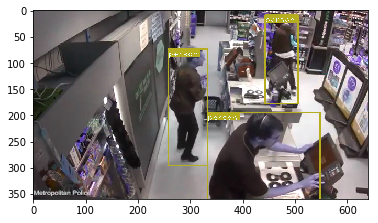

In [11]:
boxed_imgs = [img.copy() for img in video_list]
nb_second = int(np.max(frames_df.second))
for i in range(nb_second):
    img = boxed_imgs[i]
    filtered_df = frames_df[frames_df.second==i]
    for j in range(filtered_df.shape[0]):
        annotations = filtered_df.iloc[j]
        boxed_img = draw_box(img,annotations)
plt.imshow(boxed_imgs[15])